# Artist Identification

### TODO
* Work more on the visualization of results

In [2]:
# Plotting
from matplotlib.colors import ListedColormap

# Preprocessing and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import time

# Classifiers 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

# Dimensionality reduction libraries
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

#Other libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import dump, load
import json
import os

# Feature Extraction

### Importing extracted and saved features

In [3]:
import pickle

hu_moments_list_tuple = (pickle.load( open( "Feature Extraction/Hu Moments.pkl", "rb" ) ))
histograms_list_tuple = (pickle.load( open( "Feature Extraction/Color Histograms.pkl", "rb" ) ))
hog_list_tuple = (pickle.load( open( "Feature Extraction/HOGs.pkl", "rb" ) ))
lbp_list_tuple = (pickle.load( open( "Feature Extraction/Resized_LPBs.pkl", "rb" ) ))
sift_list_tuple = (pickle.load( open( "Feature Extraction/SIFTs.pkl", "rb" ) ))


### Converting artist names to labels

In [4]:
type([x[1] for x in histograms_list_tuple])
names = [x[1] for x in histograms_list_tuple]
d = {ni: indi for indi, ni in enumerate(set(names))}
y = np.array([d[ni] for ni in names])
print("Training set details:")
print("Artist-label map:", d)
print("Total number of images:",y.shape[0])
print("Diego:",y[y==0].shape[0])
print("Rembrandt:",y[y==1].shape[0])
print("Caravaggio:",y[y==2].shape[0])
print("Peter:",y[y==3].shape[0])

Training set details:
Artist-label map: {'Peter': 0, 'Caravaggio': 1, 'Diego': 2, 'Rembrandt': 3}
Total number of images: 586
Diego: 141
Rembrandt: 55
Caravaggio: 128
Peter: 262


In [5]:
hu_moments = np.squeeze(np.array([x[2] for x in hu_moments_list_tuple]))
histograms = np.reshape(np.squeeze(np.array([x[2] for x in histograms_list_tuple])),(len(hu_moments_list_tuple),-1))
hog = np.squeeze(np.array([x[2] for x in hog_list_tuple]))
lbp = np.reshape(np.squeeze(np.array([x[2] for x in lbp_list_tuple])),(len(hu_moments_list_tuple),-1))
# sift = np.squeeze(np.array([x[2] for x in sift_list_tuple]))

# Feature dimensions
print("(Number of images, Number of features)")
print("Hu Moments:",hu_moments.shape)
print("Histograms:",histograms.shape)
print("HoG:",hog.shape)
print("LBP:",lbp.shape)
# print("SIFT:",sift.shape)

(Number of images, Number of features)
Hu Moments: (586, 7)
Histograms: (586, 768)
HoG: (586, 680400)
LBP: (586, 40000)


In [6]:
datasets = [(hu_moments,y), (histograms,y), (lbp,y)]
# datasets = [(hu_moments,y)]

# Dimensionality reduction

In [7]:
# Dimensionality reduction algorithms
dr_names = ["kpca","lda","tsne"]

In [8]:
# Apply dimensionality reduction to the dataset

def dim_red(X, y, best_params):
#     {'reduce_dim': KernelPCA(kernel='rbf', n_components=4), 'reduce_dim__kernel': 'rbf', 'reduce_dim__n_components': 4}
    dr = best_params['reduce_dim']
    
    X_dr = dr.fit_transform(X, y)
    
    return X_dr

# GridSearchCV

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin #gives fit_transform method for free
#Since TSNE does not have a transform method
class tSNE(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.model = TSNE(n_components)
    
    def fit(self, X, y=None):
#         self.model.fit(X)
        return self
    
    def transform(self, X, y=None):
        return self.model.fit_transform(X)

In [17]:
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

def tune_clf(X_train, y_train, parameters, num_fold, clf_name):
    
    # Define the pipeline
    pipe = Pipeline([
        ('reduce_dim', KernelPCA()),
        ('classify', KNeighborsClassifier(3))
    ])

    # Use kFold CV for evaluating the pipeline
    kf = KFold(n_splits = num_fold, shuffle = False)
    
    # Define the paramters to search over for dimensionality reduction
    
    # Change N_FEATURES_OPTIONS for different types of features
    num_feat = X_train.shape[1]
    N_FEATURES_TSNE = [2, 3]
    if num_feat < 8:
        N_FEATURES_OPTIONS = [2, 4, 6]
    elif num_feat < 1000:
        N_FEATURES_OPTIONS = [10, 100, 200]
    else:
        N_FEATURES_OPTIONS = [10, 100, 500, 1000]
        
    KERNELS = ['linear', 'rbf', 'poly']
    
    # Define the parameters to search over for the classifiers
    #KNN
    N_NEIGHBORS = [2, 3, 4, 5, 6, 7, 8]
    #SVM
    CS = [0.025, 0.05, 0.1, 1]
    GAMMAS = [0.1, 1, 10]
    #Gaussian Process
    KERNELS_GP = [1.0 *RBF(1.0), DotProduct(), WhiteKernel(noise_level=0.5), DotProduct() + WhiteKernel(noise_level=0.5)]
    #Decision Tree
    CRITERIA = ['gini', 'entropy']
    SPLITTERS = ['best', 'random']
    MAX_DEPTHS = [5, 10, 15]
    #MLP
    ALPHAS = [0.001, 0.01, 0.1, 1.0]
    LAYERS = [(100,20,10), (100,50,20), (100,100,20)]
    #AdaBoost
    LEARNING_RATES = [0.01, 0.1, 1.0]    
    
    param_grid = [
            {
                'reduce_dim': [KernelPCA()],
                'reduce_dim__n_components': N_FEATURES_OPTIONS,
                'reduce_dim__kernel': KERNELS
            },
            {
                'reduce_dim': [LinearDiscriminantAnalysis(n_components=3)],
            },
            {
                'reduce_dim': [tSNE()],
                'reduce_dim__n_components': N_FEATURES_TSNE,
            },
        ]
    
    for i in range(3):
        if clf_name == "Nearest Neighbors":
            param_grid[i]['classify'] = [KNeighborsClassifier()]
            param_grid[i]['classify__n_neighbors'] = N_NEIGHBORS
        
        if clf_name == "SVM":
            param_grid[i]['classify'] = [SVC(max_iter = 100000)]
            param_grid[i]['classify__kernel'] = KERNELS
            param_grid[i]['classify__C'] = CS
            param_grid[i]['classify__gamma'] = GAMMAS
        
        if clf_name == "Gaussian Process":
            param_grid[i]['classify'] = [GaussianProcessClassifier()]
#             param_grid[i]['classify__kernel'] = KERNELS_GP
            
        if clf_name == "Decision Tree":
            param_grid[i]['classify'] = [DecisionTreeClassifier()]
            param_grid[i]['classify__criterion'] = CRITERIA
            param_grid[i]['classify__splitter'] = SPLITTERS
            param_grid[i]['classify__max_depth'] = MAX_DEPTHS
            
        if clf_name == "Random Forest":
            param_grid[i]['classify'] = [RandomForestClassifier()]
            param_grid[i]['classify__criterion'] = CRITERIA
            param_grid[i]['classify__max_depth'] = MAX_DEPTHS
            
        if clf_name == "Neural Net":
            param_grid[i]['classify'] = [MLPClassifier()]
            param_grid[i]['classify__alpha'] = ALPHAS
            param_grid[i]['classify__hidden_layer_sizes'] = LAYERS
            
        if clf_name == "AdaBoost":
            param_grid[i]['classify'] = [AdaBoostClassifier()]
            param_grid[i]['classify__learning_rate'] = LEARNING_RATES
            
        if clf_name == "Naive Bayes":
            param_grid[i]['classify'] = [GaussianNB()]
            
        if clf_name == "QDA":
            param_grid[i]['classify'] = [QuadraticDiscriminantAnalysis()]

#     grid = GridSearchCV(pipe, cv=kf, n_jobs=6, param_grid=param_grid, scoring='accuracy')
    grid = RandomizedSearchCV(pipe, cv=kf, n_jobs=6, param_distributions=param_grid, scoring='accuracy')
    grid.fit(X_train, y_train)

    mean_scores = np.array(grid.cv_results_['mean_test_score'])
    acc = np.max(mean_scores)
#     print(acc)
    best_params = grid.best_params_
    return best_params

# Classifiers

In [11]:
classifier_names = [
         # "Perceptron",
         "Nearest Neighbors", 
         "SVM", 
#          "RBF SVM", 
         "Gaussian Process",
         "Decision Tree", 
         "Random Forest", 
         "Neural Net", 
         "AdaBoost",
         "Naive Bayes", 
         "QDA"]

In [12]:
classifiers = [
    #Perceptron(tol=1e-3, random_state=0),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

**Metrics**

In [13]:
def calculate_precision_recall_f1score_support(y_pred,y_true):
    return precision_recall_fscore_support(y_true, y_pred, average=None)

{'reduce_dim__n_components': 4, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=4), 'classify__n_neighbors': 8, 'classify': KNeighborsClassifier(n_neighbors=8)}
{'reduce_dim__n_components': 6, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=6), 'classify__kernel': 'poly', 'classify__gamma': 10, 'classify__C': 1, 'classify': SVC(C=1, gamma=10, kernel='poly')}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'reduce_dim__n_components': 4, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=4), 'classify__kernel': DotProduct(sigma_0=1), 'classify': GaussianProcessClassifier(kernel=DotProduct(sigma_0=1))}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'reduce_dim__n_components': 6, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=6), 'classify__splitter': 'best', 'classify__max_depth': 5, 'classify__criterion': 'entropy', 'classify': DecisionTreeClassifier(criterion='entropy', max_depth=5)}
{'reduce_dim': LinearDiscriminantAnalysis(n_components=3), 'classify__max_depth': 5, 'classify__criterion': 'entropy', 'classify': RandomForestClassifier(criterion='entropy', max_depth=5)}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'reduce_dim__n_components': 6, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=6), 'classify__hidden_layer_sizes': (100, 50, 20), 'classify__alpha': 0.001, 'classify': MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 50, 20))}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'reduce_dim__n_components': 6, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=6), 'classify__learning_rate': 0.01, 'classify': AdaBoostClassifier(learning_rate=0.01)}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'reduce_dim__n_components': 2, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=2), 'classify': GaussianNB()}
{'reduce_dim__n_components': 2, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=2), 'classify': QuadraticDiscriminantAnalysis()}
{'reduce_dim__n_components': 200, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=200), 'classify__n_neighbors': 6, 'classify': KNeighborsClassifier(n_neighbors=6)}
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=10), 'classify__kernel': 'linear', 'classify__gamma': 1, 'classify__C': 0.1, 'classify': SVC(C=0.1, gamma=1, kernel='linear')}
{'reduce_dim__n_components': 200, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=200), 'classify__kernel': 1**2 * RBF(length_scale=1), 'classify': GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))}
{'reduce_dim__n_components'

C:\Users\sc699\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=10), 'classify__learning_rate': 0.1, 'classify': AdaBoostClassifier(learning_rate=0.1)}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify': GaussianNB()}
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify': QuadraticDiscriminantAnalysis()}
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=100), 'classify__n_neighbors': 6, 'classify': KNeighborsClassifier(n_neighbors=6)}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=100), 'classify__kernel': 'linear', 'classify__gamma': 1, 'classify__C': 1, 'classify': SVC(C=1, gamma=1, kernel='linear', max_iter=100000)}
{'reduce_dim': LinearDiscriminantAnalysis(n_components=3), 'classify': GaussianProcessClassifier()}
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=100), 'classify__splitter': 'random', 'classify__max_depth': 10, 'classify__criterion': 'gini', 'classify': DecisionTreeClassifier(max_depth=10, splitter='random')}
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify__max_depth': 10, 'classify__criterion': 'entropy', 'classify': RandomForestClassifier(criterion='entropy', max_depth=10)}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=100), 'classify__hidden_layer_sizes': (100, 100, 20), 'classify__alpha': 0.1, 'classify': MLPClassifier(alpha=0.1, hidden_layer_sizes=(100, 100, 20))}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=100), 'classify__learning_rate': 0.01, 'classify': AdaBoostClassifier(learning_rate=0.01)}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=10), 'classify': GaussianNB()}
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify': QuadraticDiscriminantAnalysis()}


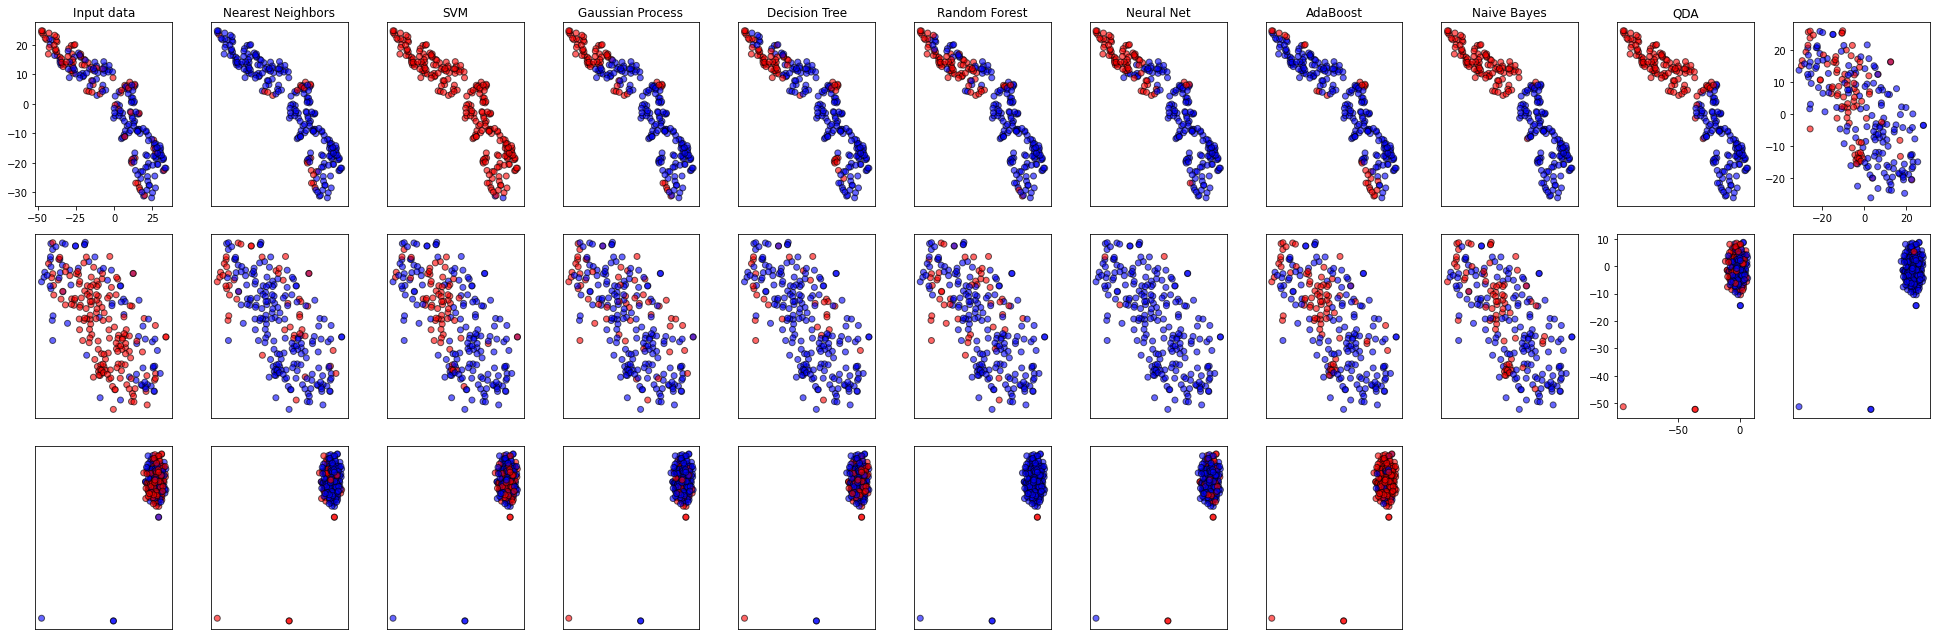

In [18]:
# Initialization
h = 0.02
metrics = {}
all_scores = []
all_times = []

figure = plt.figure(figsize=(27, 9))
im_count = 1

tsne = TSNE(n_components=2)

# Iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    
    # Preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
    n_train = X_train.shape[0]
    
    # Plot the train and test dataset in 2D using tSNE
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF',])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, im_count)
    if ds_cnt == 0:
        ax.set_title("Input data")
    
    X_embedded = tsne.fit_transform(np.append(X_train,X_test,axis=0))
#     # Plot the training points
#     ax.scatter(X_embedded[:n_train, 0], X_embedded[:n_train, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    # Plot the testing points
    ax.scatter(X_embedded[n_train:, 0], X_embedded[n_train:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')
    
    im_count += 1
    
    # Iterate over classifiers
    scores = []
    times = []
    
#     for name, clf in zip(classifier_names, classifiers):
    for name in classifier_names:
        
        ax = plt.subplot(len(datasets), len(classifiers) + 1, im_count)
        
        # Find the best parameters for the classifier and dim. red. algorithm        
        best_params_path = 'Best_params/best_params_'+name+'_'+str(ds_cnt)+'.pkl'
        t0 = time.time()
        if os.path.exists(best_params_path):
#             with open(best_params_path) as fp:
#                 best_params = json.load(fp)
            best_params  = load(best_params_path)
        else:
#             print('here')
            best_params = tune_clf(X_train, y_train, [] , 5, name)
            dump(best_params,best_params_path)
#             with open(best_params_path, 'w') as fp:
#                 fp.write(json.dumps(best_params))
        print(best_params)
        
        # Apply dimensionality reduction to the dataset using the parameters from grid search CV
        X_train_dr = dim_red(X_train, y_train, best_params)
        X_test_dr = dim_red(X_test, y_test, best_params)
        
        # Get the paramaters for the classifier from 
        clf = best_params['classify']
        
        # Fit the classifier to the train dataset
        clf.fit(X_train_dr, y_train)
        t1 = time.time()
        score = clf.score(X_test_dr, y_test)

        # Plot the predictions on the test dataset
        ax.scatter(X_embedded[n_train:, 0], X_embedded[n_train:, 1], c=clf.predict(X_test_dr), cmap=cm_bright,
                   edgecolors='k', alpha=0.6)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        im_count += 1
        
        # Compute metrics
        metrics[name]=calculate_precision_recall_f1score_support(clf.predict(X_test_dr),y_test)
        scores.append([name, score])
        times.append([name, (t1-t0)])
        
    all_scores.append(scores)
    all_times.append(times)
    
plt.tight_layout()
plt.show()

# Results

In [25]:
# !pip install termtables

In [ ]:
# !pip install seaborn

+-------------------+---------------------+
| Classifier        | Score               |
+===================+=====================+
| Nearest Neighbors | 0.425531914893617   |
+-------------------+---------------------+
| SVM               | 0.09361702127659574 |
+-------------------+---------------------+
| Gaussian Process  | 0.574468085106383   |
+-------------------+---------------------+
| Decision Tree     | 0.46382978723404256 |
+-------------------+---------------------+
| Random Forest     | 0.4851063829787234  |
+-------------------+---------------------+
| Neural Net        | 0.5276595744680851  |
+-------------------+---------------------+
| AdaBoost          | 0.4765957446808511  |
+-------------------+---------------------+
| Naive Bayes       | 0.49361702127659574 |
+-------------------+---------------------+
| QDA               | 0.48936170212765956 |
+-------------------+---------------------+


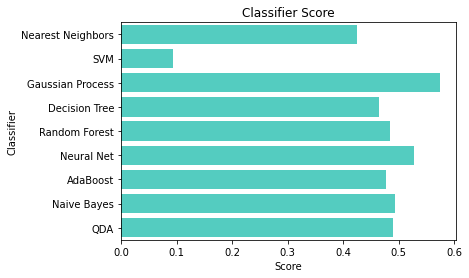

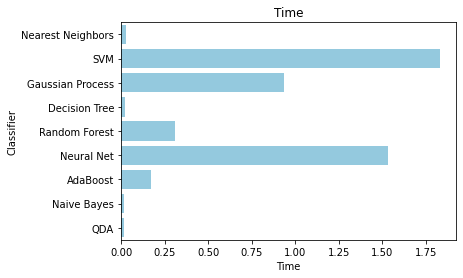

+-------------------+---------------------+
| Classifier        | Score               |
+===================+=====================+
| Nearest Neighbors | 0.37446808510638296 |
+-------------------+---------------------+
| SVM               | 0.4340425531914894  |
+-------------------+---------------------+
| Gaussian Process  | 0.6510638297872341  |
+-------------------+---------------------+
| Decision Tree     | 0.37446808510638296 |
+-------------------+---------------------+
| Random Forest     | 0.4595744680851064  |
+-------------------+---------------------+
| Neural Net        | 0.3872340425531915  |
+-------------------+---------------------+
| AdaBoost          | 0.41702127659574467 |
+-------------------+---------------------+
| Naive Bayes       | 0.6595744680851063  |
+-------------------+---------------------+
| QDA               | 0.5829787234042553  |
+-------------------+---------------------+


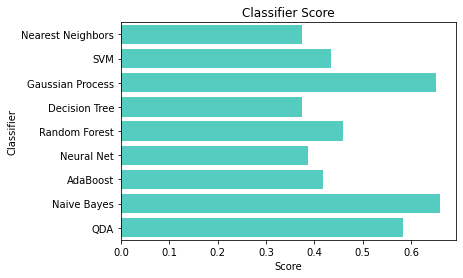

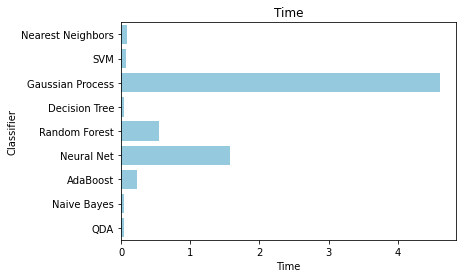

+-------------------+---------------------+
| Classifier        | Score               |
+===================+=====================+
| Nearest Neighbors | 0.43829787234042555 |
+-------------------+---------------------+
| SVM               | 0.22127659574468084 |
+-------------------+---------------------+
| Gaussian Process  | 0.4723404255319149  |
+-------------------+---------------------+
| Decision Tree     | 0.33191489361702126 |
+-------------------+---------------------+
| Random Forest     | 0.3829787234042553  |
+-------------------+---------------------+
| Neural Net        | 0.30638297872340425 |
+-------------------+---------------------+
| AdaBoost          | 0.4425531914893617  |
+-------------------+---------------------+
| Naive Bayes       | 0.3872340425531915  |
+-------------------+---------------------+
| QDA               | 0.23404255319148937 |
+-------------------+---------------------+


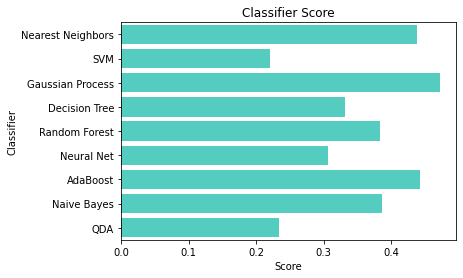

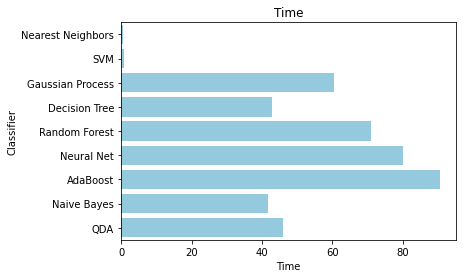

+-------------------+--------------------+
| Classifier        | Time               |
+===================+====================+
| Nearest Neighbors | 0.5514156818389893 |
+-------------------+--------------------+
| SVM               | 0.7512655258178711 |
+-------------------+--------------------+
| Gaussian Process  | 60.587007999420166 |
+-------------------+--------------------+
| Decision Tree     | 42.96756052970886  |
+-------------------+--------------------+
| Random Forest     | 70.89860486984253  |
+-------------------+--------------------+
| Neural Net        | 79.95107841491699  |
+-------------------+--------------------+
| AdaBoost          | 90.52427744865417  |
+-------------------+--------------------+
| Naive Bayes       | 41.67325830459595  |
+-------------------+--------------------+
| QDA               | 45.998879194259644 |
+-------------------+--------------------+
Classifier          Diego                Rembrandt            Peter                Caravaggio    

In [19]:
import termtables as tt
import seaborn as sns

for i,d in enumerate(datasets):
    # Classifier scores -
    # Table
    string = tt.to_string(
        all_scores[i],
        header=["Classifier", "Score"],
        style=tt.styles.ascii_thin_double,
        # alignment="ll",
        # padding=(0, 1),
    )
    print(string)
    
    # Histogram
    log = pd.DataFrame(all_scores[i], columns=["Classifier", "Score"])
#     print(log)
    sns.set_color_codes("pastel")
    sns.barplot(x='Score', y='Classifier', data=log, color = 'turquoise')

    plt.xlabel('Score')
    plt.title('Classifier Score')
    plt.show()
    

    string = tt.to_string(
        all_times[i],
        header=["Classifier", "Time"], #Check this!
        style=tt.styles.ascii_thin_double,
        # alignment="ll",
        # padding=(0, 1),
    )
    
    log = pd.DataFrame(all_times[i], columns=["Classifier", "Time"])
    sns.set_color_codes("pastel")
    sns.barplot(x='Time', y='Classifier', data=log, color = 'skyblue')

    plt.xlabel('Time')
    plt.title('Time')
    plt.show()
    
    
print(string)

measure = ["precision", "recall", "fbeta_score", "support"]
print ("{:<20}{:<20} {:<20} {:<20} {:<20}".format('Classifier','Diego', 'Rembrandt', 'Peter', 'Caravaggio'))
for k, v in metrics.items():
 
    for i in range(4):
        
        print ("{:<20} {:<20} {:<20} {:<20} {:<20}".format(k,v[i][0],v[i][1],v[i][2],v[i][3]))